# Task 2 — Quantitative Analysis (TA‑Lib + PyNance)

This notebook computes technical indicators (SMA, EMA, RSI, MACD) using `TA-Lib` when available, falls back to `pandas_ta` or pure-pandas implementations, computes simple financial metrics (returns, annualized volatility, simple Sharpe-like ratio), and provides visualizations.

KPIs:
- Compute indicators accurately using TA-Lib if present, otherwise use fallbacks.
- Produce clear visualizations and sample metrics for a chosen stock CSV from the `Data/` folder.

In [1]:
# Standard imports and environment checks
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# Prefer TA-Lib if available; otherwise try pandas_ta; otherwise use pure-pandas implementations
use_talib = False
use_pandas_ta = False
talib_err = None
pandas_ta_err = None
try:
    import talib
    use_talib = True
    print('Using TA-Lib')
except Exception as e:
    talib_err = e
    print('TA-Lib not available:', e)
    # try pandas_ta, but guard against numba/numpy incompatibility errors
    try:
        import pandas_ta as pta
        use_pandas_ta = True
        print('Imported pandas_ta')
    except Exception as e2:
        pandas_ta_err = e2
        print('pandas_ta not available or incompatible — will use pure-pandas fallback:', e2)

# Pure-pandas indicator implementations (used when talib/pandas_ta aren't available)
def sma(series, window):
    return series.rolling(window).mean()
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()
def rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))
def macd_lines(series, fast=12, slow=26, signal=9):
    fast_ema = ema(series, fast)
    slow_ema = ema(series, slow)
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

TA-Lib not available: No module named 'talib'


Imported pandas_ta


In [2]:
# Locate Data folder (search upward if necessary)
def find_repo_root_with_data(start=Path('.'), max_up=6):
    p = start.resolve()
    for _ in range(max_up):
        if (p / 'Data').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start.resolve()
ROOT = find_repo_root_with_data(Path('.'))
DATA_DIR = ROOT / 'Data'
print('Data directory:', DATA_DIR)
csvs = list(DATA_DIR.glob('*.csv')) if DATA_DIR.exists() else []
print('CSV files found:', len(csvs))
sample_csv = DATA_DIR / 'AAPL.csv' if (DATA_DIR / 'AAPL.csv').exists() else (csvs[0] if csvs else None)
sample_csv

Data directory: C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data
CSV files found: 7


WindowsPath('C:/Users/nesre/Desktop/10 Acadamey/tenx KAIM 8/Predicting Price Moves with News Sentiment/Data/AAPL.csv')

In [3]:
# Load sample CSV and prepare DataFrame
if sample_csv is None:
    raise FileNotFoundError('No CSV files found under Data/')
df = pd.read_csv(sample_csv, parse_dates=['Date'], infer_datetime_format=True)
# Normalize column names
df.columns = [c.strip() for c in df.columns]
if 'date' in [c.lower() for c in df.columns]:
    date_col = [c for c in df.columns if c.lower()=='date'][0]
    df = df.rename(columns={date_col: 'Date'})
df = df.sort_values('Date').reset_index(drop=True)
df = df.set_index('Date')
print('Loaded', sample_csv.name, 'rows:', len(df))
df.head()

Loaded AAPL.csv rows: 3774


,Close,High,Low,Open,Volume
Date,,,,,
2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400
2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800
2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800


In [4]:
# Indicators: SMA(20), EMA(20), RSI(14), MACD (with fallbacks)
window = 20
try:
    if use_talib:
        df['SMA_20'] = talib.SMA(df['Close'].values, timeperiod=window)
        df['EMA_20'] = talib.EMA(df['Close'].values, timeperiod=window)
        df['RSI_14'] = talib.RSI(df['Close'].values, timeperiod=14)
        macd, macd_sig, macd_hist = talib.MACD(df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD'] = macd
        df['MACD_Signal'] = macd_sig
    elif use_pandas_ta:
        try:
            # pandas_ta exposes functions; use them if available
            df['SMA_20'] = pta.sma(df['Close'], length=window)
            df['EMA_20'] = pta.ema(df['Close'], length=window)
            df['RSI_14'] = pta.rsi(df['Close'], length=14)
            macd_res = pta.macd(df['Close'], fast=12, slow=26, signal=9)
            # pandas_ta returns a DataFrame for macd when applied to series
            if hasattr(macd_res, 'iloc'):
                df['MACD'] = macd_res.iloc[:,0]
                if macd_res.shape[1] > 1:
                    df['MACD_Signal'] = macd_res.iloc[:,1]
        except Exception as e:
            print('pandas_ta usage failed, falling back to pandas functions:', e)
            df['SMA_20'] = sma(df['Close'], window)
            df['EMA_20'] = ema(df['Close'], window)
            df['RSI_14'] = rsi(df['Close'], 14)
            df['MACD'], df['MACD_Signal'], _ = macd_lines(df['Close'])
    else:
        # pure-pandas fallback implementations
        df['SMA_20'] = sma(df['Close'], window)
        df['EMA_20'] = ema(df['Close'], window)
        df['RSI_14'] = rsi(df['Close'], 14)
        df['MACD'], df['MACD_Signal'], _ = macd_lines(df['Close'])
except Exception as exc:
    print('Indicator calculation failed:', exc)

df[['Close','SMA_20','EMA_20','RSI_14','MACD']].tail()

,Close,SMA_20,EMA_20,RSI_14,MACD
Date,,,,,
2023-12-22,191.788757,191.856618,191.510231,54.672784,2.633141
2023-12-26,191.243912,192.018094,191.484867,53.090049,2.304751
2023-12-27,191.342972,192.154308,191.471353,53.354446,2.029104
2023-12-28,191.768951,192.362839,191.499696,54.540999,1.823998
2023-12-29,190.728775,192.490633,191.426275,51.121347,1.559539


In [5]:
# Financial metrics: returns, annualized volatility, simple Sharpe-like ratio
df['ret'] = df['Close'].pct_change()
lookback = 252
ann_vol = df['ret'].rolling(lookback).std() * (252**0.5)
ann_ret = df['ret'].rolling(lookback).mean() * 252
df['sharpe_rolling'] = ann_ret / (ann_vol.replace(0, np.nan))
print('Sample latest annualized return:', ann_ret.dropna().iloc[-1] if ann_ret.dropna().any() else None)
print('Sample latest annualized vol:', ann_vol.dropna().iloc[-1] if ann_vol.dropna().any() else None)
df[['ret']].head()

Sample latest annualized return: 0.4502855339952546
Sample latest annualized vol: 0.20394062595435608


,ret
Date,
2009-01-02,NaN
2009-01-05,0.042204
2009-01-06,-0.016494
2009-01-07,-0.021609
2009-01-08,0.018570


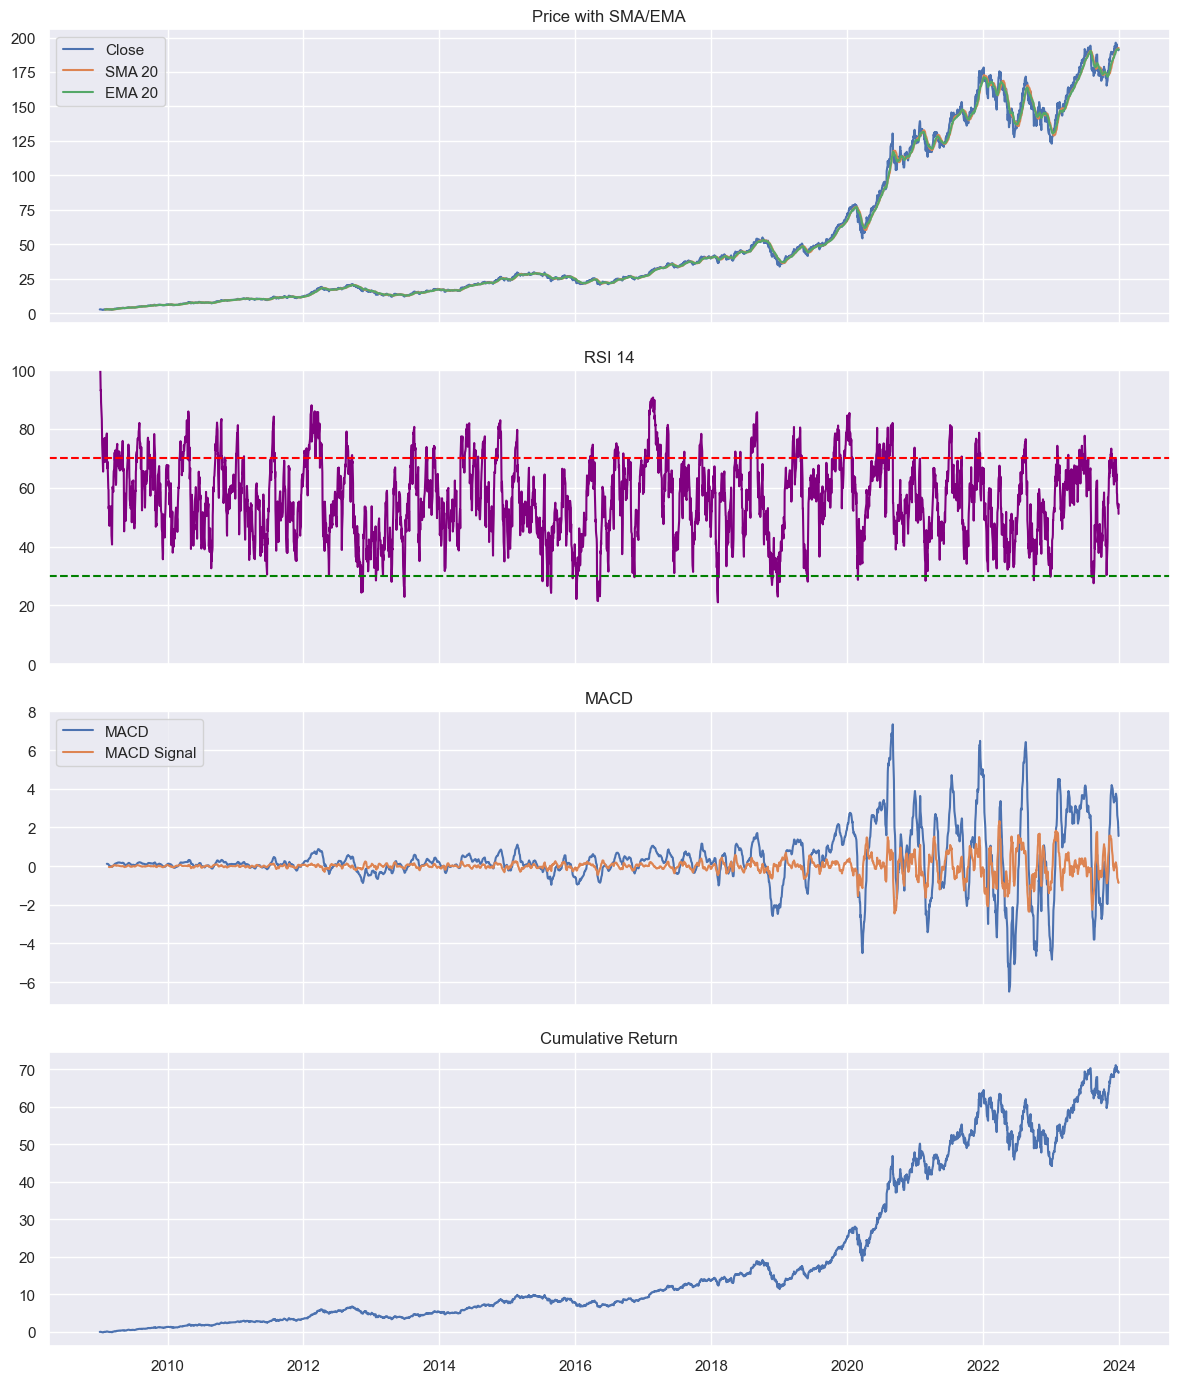

In [6]:
# Plots: price + MAs, RSI, MACD, cumulative returns
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
axes[0].plot(df.index, df['Close'], label='Close')
if 'SMA_20' in df.columns:
    axes[0].plot(df.index, df['SMA_20'], label='SMA 20')
if 'EMA_20' in df.columns:
    axes[0].plot(df.index, df['EMA_20'], label='EMA 20')
axes[0].legend(); axes[0].set_title('Price with SMA/EMA')
if 'RSI_14' in df.columns:
    axes[1].plot(df.index, df['RSI_14'], label='RSI 14', color='purple')
    axes[1].axhline(70, color='red', linestyle='--')
    axes[1].axhline(30, color='green', linestyle='--')
    axes[1].set_ylim(0,100)
    axes[1].set_title('RSI 14')
if 'MACD' in df.columns:
    axes[2].plot(df.index, df['MACD'], label='MACD')
    axes[2].plot(df.index, df['MACD_Signal'], label='MACD Signal')
    axes[2].legend(); axes[2].set_title('MACD')
df['cum_ret'] = (1 + df['ret'].fillna(0)).cumprod() - 1
axes[3].plot(df.index, df['cum_ret'], label='Cumulative Return')
axes[3].set_title('Cumulative Return')
plt.tight_layout(); plt.show()